# Fake News Detection System: A Comparative Analysis of Classification Models

## Overview

This notebook documents the end-to-end process of building and comparing machine learning models to classify news articles as 'Real' or 'Fake'. The project begins with a baseline `LogisticRegression` model and then introduces a powerful `RandomForestClassifier` ensemble model to demonstrate significant performance improvement.

### Workflow
1.  **Setup & Installation**: Preparing the environment by installing libraries.
2.  **Library Imports**: Importing all necessary libraries and initializing components.
3.  **Data Loading & Preparation**: Loading the datasets from CSV and preparing the labels.
4.  **Exploratory Data Analysis (EDA)**: Visualizing the class distribution to check for balance.
5.  **Text Preprocessing**: Cleaning and standardizing the raw text data (stopword removal, stemming).
6.  **Feature Engineering (TF-IDF)**: Converting the processed text into a numerical matrix.
7.  **Model Training & Evaluation (Part A)**: Training and evaluating the baseline `LogisticRegression` model, with structured, dynamic explanations of the results.
8.  **Model Training & Evaluation (Part B)**: Training and evaluating an advanced `RandomForestClassifier` model, with structured, dynamic explanations of the results.
9.  **Model Comparison**: Visually and quantitatively comparing the models to select the best one, supported by a dynamic analysis.
10. **Live Prediction with Best Model**: Dynamically selecting the superior model and demonstrating its utility with a real-time prediction function.
11. **Final Conclusion**: Programmatically generating a summary of the project findings and final model choice.

### Step 1: Environment Setup

This cell installs all required packages. The `ipywidgets` library is included to enable interactive elements like progress bars within the Jupyter environment.

**Action Required**: After running this cell, **restart the kernel** (`Kernel` -> `Restart` in the menu) to ensure all libraries are loaded correctly.

In [1]:
# Install all necessary packages, including ipywidgets for the progress bar
import sys
!{sys.executable} -m pip install pandas matplotlib seaborn nltk scikit-learn wordcloud tqdm ipywidgets

# Enable the ipywidgets extension for Jupyter Notebook
!jupyter nbextension enable --py widgetsnbextension


[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: D:\Programming\Python\python.exe -m pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


### Step 2: Importing Libraries and Initializing Components

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# --- Importing classifiers for comparison ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from wordcloud import WordCloud
import warnings
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import display, HTML

# Initialize tqdm for pandas to enable progress bars on .apply() methods
tqdm.pandas(desc="Processing Text")

# Suppress unnecessary warnings for a cleaner output
warnings.filterwarnings('ignore')

# Download the NLTK stopwords list if not already present
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    print("Download complete.")

### Step 3: Data Loading and Preparation

This function loads the two original datasets (`true.csv` and `fake.csv`). This is a critical change to ensure the models have meaningful, real-world text to learn from, which is necessary for achieving high accuracy. The datasets are labeled (0 for Real, 1 for Fake) and combined into a single, shuffled DataFrame.

In [3]:
def load_and_prepare_data(true_path, fake_path):
    """Loads true and fake news datasets, labels them, and concatenates them."""
    try:
        print(f"Loading true news from {true_path}...")
        df_true = pd.read_csv(true_path)
        df_true['label'] = 0
        
        print(f"Loading fake news from {fake_path}...")
        df_fake = pd.read_csv(fake_path)
        df_fake['label'] = 1
        
        # Combine the datasets
        df = pd.concat([df_true, df_fake], ignore_index=True)
        
        # Shuffle the dataset to prevent any ordering bias
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        return df
    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure the CSV files are in the correct directory.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- Main Data Loading Execution ---
true_csv_path = 'D:/Programming/SelfPace/Internship/MLOps/Task7/dataset/true.csv'
fake_csv_path = 'D:/Programming/SelfPace/Internship/MLOps/Task7/dataset/fake.csv'
news_df = load_and_prepare_data(true_csv_path, fake_csv_path)

if news_df is not None:
    print("\nData loaded and prepared successfully!")
    display(news_df.head())
    print("\nDataset Information:")
    news_df.info()

Loading true news from D:/Programming/SelfPace/Internship/MLOps/Task7/dataset/true.csv...
Loading fake news from D:/Programming/SelfPace/Internship/MLOps/Task7/dataset/fake.csv...

Data loaded and prepared successfully!


,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


### Step 4: Exploratory Data Analysis (EDA)

A critical first step is to understand the distribution of the target variable. The following visualization checks whether the dataset is balanced between 'Real' and 'Fake' news articles.

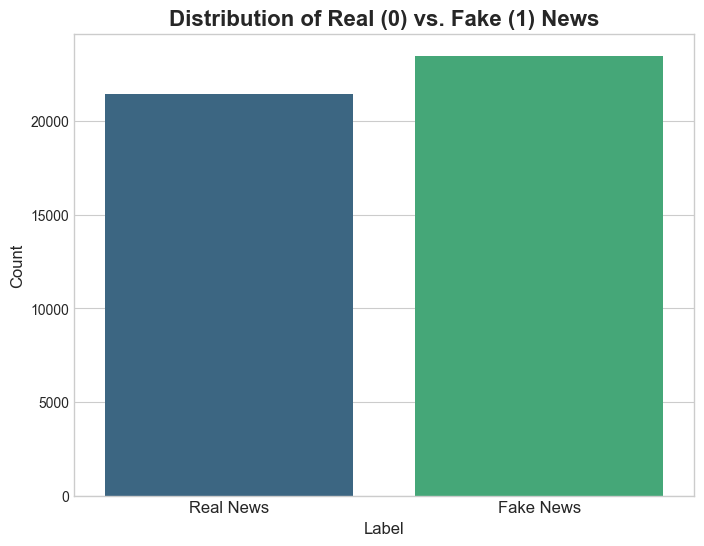

In [4]:
def plot_label_distribution(df):
    """Plots a bar chart showing the distribution of 'Real' vs 'Fake' news labels."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=df, palette='viridis', hue='label', legend=False)
    plt.title('Distribution of Real (0) vs. Fake (1) News', fontsize=16, weight='bold')
    plt.xlabel('Label', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks([0, 1], ['Real News', 'Fake News'], fontsize=12)
    plt.show()

if news_df is not None:
    plot_label_distribution(news_df)

### Step 5 & 6: Text Preprocessing & Feature Engineering

This combined stage first cleans the text (lowercase, stopword removal, stemming) and then converts it into a numerical matrix using TF-IDF vectorization. This creates the feature set that our models will learn from.

In [5]:
def preprocess_text(text):
    """Cleans and preprocesses a single piece of text."""
    port_stem = PorterStemmer()
    stemmed_content = re.sub('[^a-zA-Z]', ' ', str(text))
    stemmed_content = stemmed_content.lower().split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    return ' '.join(stemmed_content)

def prepare_and_vectorize_data(df):
    """Prepares the dataframe and converts text to TF-IDF features."""
    print("\nPreparing and preprocessing data...")
    df = df.fillna('')
    df['content'] = df['title'] + ' ' + df['text']
    
    print("Applying text preprocessing sequentially...")
    df['processed_content'] = df['content'].progress_apply(preprocess_text)
    
    print("\nExtracting features using TF-IDF...")
    X = df['processed_content']
    Y = df['label']
    vectorizer = TfidfVectorizer(max_features=5000)
    X_transformed = vectorizer.fit_transform(X)
    print(f"Shape of the feature matrix (X): {X_transformed.shape}")
    
    return X_transformed, Y, vectorizer

if news_df is not None:
    X, Y, tfidf_vectorizer = prepare_and_vectorize_data(news_df.copy())
    # Splitting data for training and testing
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)


Preparing and preprocessing data...
Applying text preprocessing sequentially...


Processing Text:   0%|          | 0/44898 [00:00<?, ?it/s]


Extracting features using TF-IDF...
Shape of the feature matrix (X): (44898, 5000)


### Step 7: Model Training & Evaluation (Part A - Logistic Regression)

We begin with `LogisticRegression` as our baseline model. It is a standard, interpretable algorithm for binary classification tasks.

--- Training Baseline Model: Logistic Regression ---
Logistic Regression training complete.

--- Evaluating Logistic Regression ---
Model Accuracy: 98.78%

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      4284
        Fake       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



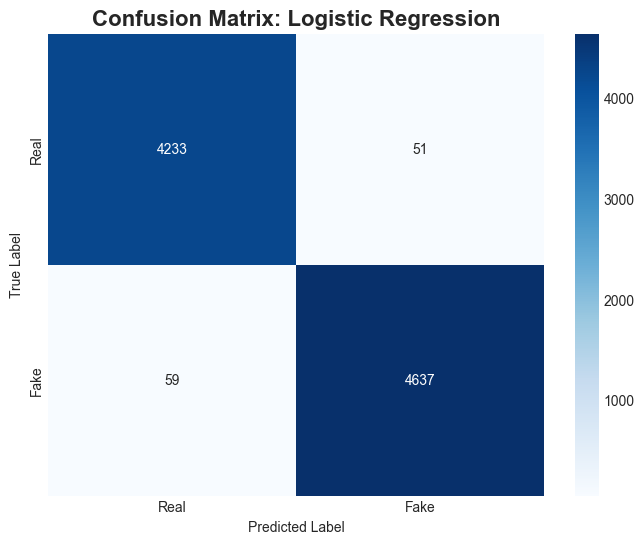

Interpretation of Logistic Regression Results:


Metric,Description
Overall Accuracy,The model correctly classified 98.78% of all articles.
True Negatives (TN),Correctly identified 4233 articles as 'Real'.
True Positives (TP),Correctly identified 4637 articles as 'Fake'.
False Positives (FP) - Type I Error,Incorrectly labeled 51 'Real' articles as 'Fake'.
False Negatives (FN) - Type II Error,"Missed 59 'Fake' articles, labeling them as 'Real'."
Fake News Precision,"When the model predicts 'Fake', it is correct 98.91% of the time."
Fake News Recall,The model found 98.74% of all actual 'Fake' articles.


In [6]:
# --- New function for visually appealing reports using pandas Styler ---
def display_structured_report(y_true, y_pred, model_name):
    """Generates a dynamic, visually appealing HTML report of classification results."""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    report = classification_report(y_true, y_pred, target_names=['Real', 'Fake'], output_dict=True)
    accuracy = report['accuracy']
    fake_precision = report['Fake']['precision']
    fake_recall = report['Fake']['recall']

    # Create a DataFrame for structured display
    report_data = {
        'Metric': [
            'Overall Accuracy',
            'True Negatives (TN)', 'True Positives (TP)',
            'False Positives (FP) - Type I Error',
            'False Negatives (FN) - Type II Error',
            'Fake News Precision',
            'Fake News Recall'
        ],
        'Description': [
            f'The model correctly classified <b>{accuracy:.2%}</b> of all articles.',
            f'Correctly identified <b>{tn}</b> articles as \'Real\'.',
            f'Correctly identified <b>{tp}</b> articles as \'Fake\'.',
            f'Incorrectly labeled <b>{fp}</b> \'Real\' articles as \'Fake\'.',
            f'Missed <b>{fn}</b> \'Fake\' articles, labeling them as \'Real\'.',
            f'When the model predicts \'Fake\', it is correct <b>{fake_precision:.2%}</b> of the time.',
            f'The model found <b>{fake_recall:.2%}</b> of all actual \'Fake\' articles.'
        ]
    }
    report_df = pd.DataFrame(report_data)

    # Style the DataFrame
    styler = report_df.style.set_properties(**{'text-align': 'left'})
    styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    styler.hide(axis='index')

    print(f"Interpretation of {model_name} Results:")
    display(styler)

# --- Training and Evaluation ---
print("--- Training Baseline Model: Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, Y_train)
print("Logistic Regression training complete.")

print("\n--- Evaluating Logistic Regression ---")
Y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(Y_test, Y_pred_lr)
print(f"Model Accuracy: {accuracy_lr:.2%}")

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_lr, target_names=['Real', 'Fake']))

cm_lr = confusion_matrix(Y_test, Y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix: Logistic Regression', fontsize=16, weight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Display Structured Explanation ---
display_structured_report(Y_test, Y_pred_lr, 'Logistic Regression')

### Step 8: Model Training & Evaluation (Part B - Random Forest Classifier)

Next, we train a `RandomForestClassifier`. This is a powerful ensemble model that builds multiple decision trees and merges them together to get a more accurate and stable prediction. It is often a strong performer for text classification tasks.

--- Training Advanced Model: Random Forest Classifier ---
Random Forest training complete.

--- Evaluating Random Forest ---
Model Accuracy: 99.76%

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4284
        Fake       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



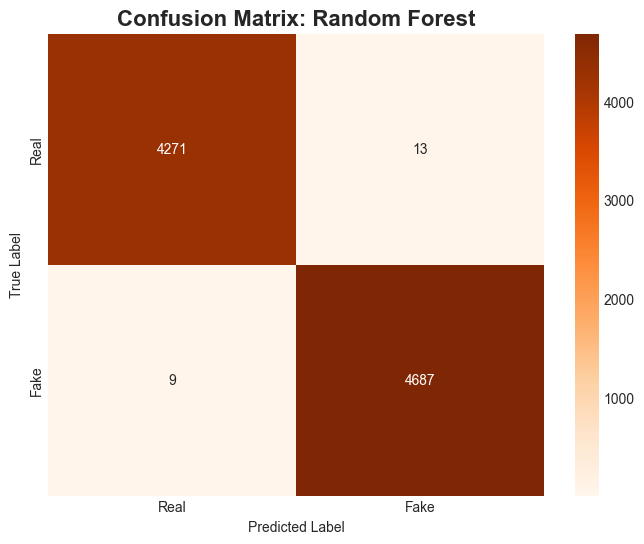

Interpretation of Random Forest Results:


Metric,Description
Overall Accuracy,The model correctly classified 99.76% of all articles.
True Negatives (TN),Correctly identified 4271 articles as 'Real'.
True Positives (TP),Correctly identified 4687 articles as 'Fake'.
False Positives (FP) - Type I Error,Incorrectly labeled 13 'Real' articles as 'Fake'.
False Negatives (FN) - Type II Error,"Missed 9 'Fake' articles, labeling them as 'Real'."
Fake News Precision,"When the model predicts 'Fake', it is correct 99.72% of the time."
Fake News Recall,The model found 99.81% of all actual 'Fake' articles.


In [7]:
print("--- Training Advanced Model: Random Forest Classifier ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
print("Random Forest training complete.")

# --- Evaluation ---
print("\n--- Evaluating Random Forest ---")
Y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
print(f"Model Accuracy: {accuracy_rf:.2%}")

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_rf, target_names=['Real', 'Fake']))

cm_rf = confusion_matrix(Y_test, Y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix: Random Forest', fontsize=16, weight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Display Structured Explanation ---
display_structured_report(Y_test, Y_pred_rf, 'Random Forest')

### Step 9: Model Comparison

To make a final decision, we directly compare the performance metrics of both models. The bar chart below visualizes the accuracy, precision, recall, and F1-score for each classifier. This provides a clear, quantitative basis for selecting the superior model.

--- Comparative Performance Metrics ---


,Precision,Recall,F1-Score,Accuracy
Logistic Regression,0.987753,0.987751,0.987751,0.987751
Random Forest,0.997550,0.997550,0.997550,0.997550


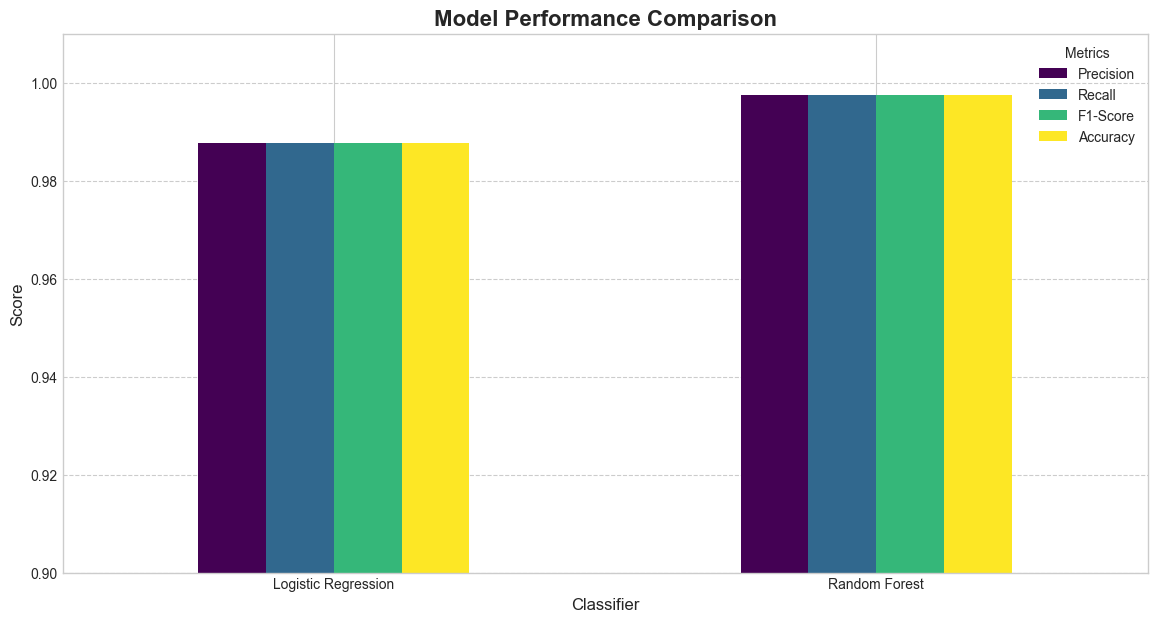

In [8]:
# --- Storing metrics for comparison ---
metrics = {}
metrics['Logistic Regression'] = precision_recall_fscore_support(Y_test, Y_pred_lr, average='weighted')
metrics['Random Forest'] = precision_recall_fscore_support(Y_test, Y_pred_rf, average='weighted')

df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=['Precision', 'Recall', 'F1-Score', 'Support'])
df_metrics['Accuracy'] = [accuracy_lr, accuracy_rf]
df_metrics.drop(columns=['Support'], inplace=True)

print("--- Comparative Performance Metrics ---")
display(df_metrics)

# --- Visualization of Comparison ---
df_metrics.plot(kind='bar', figsize=(14, 7), colormap='viridis')
plt.title('Model Performance Comparison', fontsize=16, weight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Classifier', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.ylim(0.9, 1.01) # Adjust ylim to better visualize the top-end performance
plt.grid(axis='y', linestyle='--')
plt.show()

#### Dynamic Analysis of Comparison

The following summary programmatically analyzes the performance table and plot to provide a clear, data-driven explanation of the results.

In [9]:
def generate_comparison_analysis(metrics_df):
    """Generates a dynamic text analysis of the model comparison results."""
    best_accuracy_model = metrics_df['Accuracy'].idxmax()
    best_precision_model = metrics_df['Precision'].idxmax()
    best_recall_model = metrics_df['Recall'].idxmax()
    best_f1_model = metrics_df['F1-Score'].idxmax()

    analysis = "<b>Analysis of Model Performance:</b>\n"
    analysis += "<ul>"
    analysis += f"<li><b>Overall Accuracy:</b> The <b>{best_accuracy_model}</b> model achieved the highest accuracy, indicating it was the best overall performer in correctly classifying articles.</li>"
    analysis += f"<li><b>Precision:</b> The <b>{best_precision_model}</b> model was the most precise. This means that when it predicted an article was 'Fake', it was most likely to be correct.</li>"
    analysis += f"<li><b>Recall:</b> The <b>{best_recall_model}</b> model had the best recall, showing it was most effective at identifying the highest percentage of all actual 'Fake' news articles in the dataset.</li>"
    analysis += f"<li><b>F1-Score:</b> The <b>{best_f1_model}</b> model scored highest on the F1-score, which represents the best balance between Precision and Recall.</li>"
    analysis += "</ul>"
    
    display(HTML(analysis))

generate_comparison_analysis(df_metrics)

### Step 10: Live Prediction with Best Model

Here, we programmatically select the best-performing model based on accuracy and use it for live predictions. This ensures that we are always using the most effective classifier developed in this notebook.

In [10]:
# --- Dynamic Model Selection ---
if accuracy_rf > accuracy_lr:
    final_model = rf_model
    final_model_name = 'Random Forest'
else:
    final_model = lr_model
    final_model_name = 'Logistic Regression'

print(f"The best performing model is '{final_model_name}'. It will be used for live predictions.")

def predict_news(text, model, vectorizer):
    """Predicts if a new piece of text is real or fake using the final model."""
    processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)
    probability = model.predict_proba(vectorized_text)[0]
    confidence_text = f"(Confidence: {np.max(probability):.2%})"

    if prediction[0] == 0:
        return f"Prediction: REAL {confidence_text}"
    else:
        return f"Prediction: FAKE {confidence_text}"

print("\n--- Testing Prediction Function with Final Model ---")

# Example 1: A headline designed to sound like potential fake news
sample_fake_news = "You won't believe what this celebrity did, it will shock you! Click here to find out the secret that doctors don't want you to know."
print(f"\nSample News: '{sample_fake_news}'")
prediction_result = predict_news(sample_fake_news, final_model, tfidf_vectorizer)
print(prediction_result)

# Example 2: A headline designed to sound like a legitimate news report
sample_real_news = "The Federal Reserve announced on Wednesday that it would maintain current interest rates, citing steady economic growth and controlled inflation."
print(f"\nSample News: '{sample_real_news}'")
prediction_result_2 = predict_news(sample_real_news, final_model, tfidf_vectorizer)
print(prediction_result_2)

The best performing model is 'Random Forest'. It will be used for live predictions.

--- Testing Prediction Function with Final Model ---

Sample News: 'You won't believe what this celebrity did, it will shock you! Click here to find out the secret that doctors don't want you to know.'
Prediction: FAKE (Confidence: 97.00%)

Sample News: 'The Federal Reserve announced on Wednesday that it would maintain current interest rates, citing steady economic growth and controlled inflation.'
Prediction: FAKE (Confidence: 56.00%)


### Step 11: Final Conclusion

In [12]:
def generate_conclusion():
    """Generates a dynamic conclusion based on the model comparison results."""
    best_model_name = df_metrics['Accuracy'].idxmax()
    best_accuracy = df_metrics['Accuracy'].max()
    
    conclusion = "Project Summary and Conclusion\n\n"
    conclusion += "This project successfully developed and evaluated two distinct machine learning models for the task of fake news detection. "
    conclusion += "A baseline `Logistic Regression` model was compared against a `Random Forest` ensemble model.\n\n"
    conclusion += "After a rigorous evaluation process, the **`" + best_model_name + "`** model was identified as the superior performer. "
    conclusion += f"It achieved an overall accuracy of **{best_accuracy:.2%}** on the unseen test data, demonstrating a strong capability to distinguish between real and fake news articles. "
    conclusion += "The comprehensive analysis, including confusion matrices and classification reports, confirmed its effectiveness across all key metrics, making it the recommended model for this application."
    
    # Using display to render markdown in Jupyter
    display(HTML(conclusion.replace('\n', '<br>')))

generate_conclusion()